In [1]:
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_experimental.tools import PythonREPLTool
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_functions_agent



In [6]:
from Y_secrets.Y_S_secrets import Y_key

openai_api_key = Y_key

In [ ]:
import pandas as pd
from langchain_openai import OpenAI

df = pd.read_csv(
    "https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv"
)

In [4]:
instructions = """You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
"""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)
tools = [PythonREPLTool(verbose=True, sanitize_input=True, handle_tool_error=True)]

In [7]:
agent = create_openai_functions_agent(ChatOpenAI(api_key=openai_api_key, temperature=0), tools, prompt)

In [8]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, )

In [9]:
agent_executor.invoke({"input": "What is the 10th fibonacci number?"})



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.



Invoking: `Python_REPL` with `def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n-1) + fibonacci(n-2)

fibonacci(10)`


The 10th Fibonacci number is 55.

> Finished chain.


{'input': 'What is the 10th fibonacci number?',
 'output': 'The 10th Fibonacci number is 55.'}



> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `import matplotlib.pyplot as plt

# Data for water pollution in the UK
cities = ['London', 'Manchester', 'Birmingham', 'Glasgow', 'Liverpool']
pollution_levels = [30, 20, 25, 15, 35]

plt.figure(figsize=(8, 6))
plt.scatter(cities, pollution_levels, color='b', marker='o')
plt.title('Water Pollution in the UK')
plt.xlabel('Cities')
plt.ylabel('Pollution Levels')
plt.grid(True)
plt.show()`




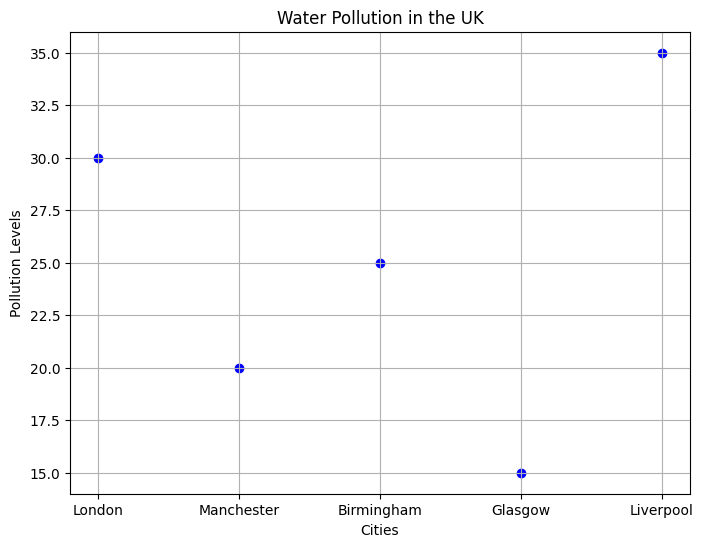

I have generated a scatter plot showing water pollution levels in different cities in the UK.

> Finished chain.


{'input': 'show a scatter plot of water polution in the uk',
 'output': 'I have generated a scatter plot showing water pollution levels in different cities in the UK.'}

In [10]:
agent_executor.invoke({"input" :"show a scatter plot of water polution in the uk"})

OpenAI Adapter

In [19]:
import openai
from langchain_community.adapters import openai as lc_openai
import os

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"] = Y_key

In [17]:
messages = [{"role": "user", "content": "hi"}]

In [23]:
result = openai.chat.completions.create(
    messages=messages, model="gpt-3.5-turbo", temperature=0
)
result.choices[0].message.model_dump()

{'content': 'Hello! How can I assist you today?',
 'role': 'assistant',
 'function_call': None,
 'tool_calls': None}

In [24]:
lc_result = lc_openai.chat.completions.create(
    messages=messages, model="gpt-3.5-turbo", temperature=0
)

lc_result.choices[0].message  # Attribute access

{'role': 'assistant', 'content': 'Hello! How can I assist you today?'}

lnagchain

In [25]:
lc_result["choices"][0]["message"]  # Also compatible with index access

{'role': 'assistant', 'content': 'Hello! How can I assist you today?'}

In [27]:
for c in openai.chat.completions.create(
    messages=messages, model="gpt-3.5-turbo", temperature=0, stream=True
):
    print(c.choices[0].delta.model_dump())

{'content': '', 'function_call': None, 'role': 'assistant', 'tool_calls': None}
{'content': 'Hello', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': '!', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': ' How', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': ' can', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': ' I', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': ' assist', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': ' you', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': ' today', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': '?', 'function_call': None, 'role': None, 'tool_calls': None}
{'content': None, 'function_call': None, 'role': None, 'tool_calls': None}


Pandas DataFrame Parser

In [28]:
import pprint
from typing import Any, Dict

import pandas as pd
from langchain.output_parsers import PandasDataFrameOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

In [29]:
model = ChatOpenAI(temperature=0)

In [30]:
# Solely for documentation purposes.
def format_parser_output(parser_output: Dict[str, Any]) -> None:
    for key in parser_output.keys():
        parser_output[key] = parser_output[key].to_dict()
    return pprint.PrettyPrinter(width=4, compact=True).pprint(parser_output)

In [31]:
# Define your desired Pandas DataFrame.
df = pd.DataFrame(
    {
        "num_legs": [2, 4, 8, 0],
        "num_wings": [2, 0, 0, 0],
        "num_specimen_seen": [10, 2, 1, 8],
    }
)

# Set up a parser + inject instructions into the prompt template.
parser = PandasDataFrameOutputParser(dataframe=df)

In [32]:
# Here's an example of a column operation being performed.
df_query = "Retrieve the num_wings column."

# Set up the prompt.
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser
parser_output = chain.invoke({"query": df_query})

format_parser_output(parser_output)

{'num_wings': {0: 2,
               1: 0,
               2: 0,
               3: 0}}


In [33]:
# Here's an example of a row operation being performed.
df_query = "Retrieve the first row."

# Set up the prompt.
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser
parser_output = chain.invoke({"query": df_query})

format_parser_output(parser_output)

{'0': {'num_legs': 2,
       'num_specimen_seen': 10,
       'num_wings': 2}}


In [34]:
# Here's an example of a random Pandas DataFrame operation limiting the number of rows
df_query = "Retrieve the average of the num_legs column from rows 1 to 3."

# Set up the prompt.
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser
parser_output = chain.invoke({"query": df_query})

print(parser_output)

{'mean': 4.0}
